In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
import os
import keras
import numpy as np
from PIL import Image
import tensorflow as tf
from random import randint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils import np_utils
from keras.optimizers import adam
from keras.models import Sequential
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from keras.preprocessing.image import img_to_array
from keras.metrics import categorical_crossentropy
#from sklearn.cross_validation import train_test_split
from keras.layers.core import Dense,Dropout,Activation,Flatten
from keras.layers.convolutional import Convolution2D,MaxPooling2D

Using TensorFlow backend.


In [3]:
import pprint
if 'COLAB_TPU_ADDR' not in os.environ:
  print('ERROR: Not connected to a TPU runtime; ')
else:
  tpu_address = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  print ('TPU address is', tpu_address)

  with tf.Session(tpu_address) as session:
    devices = session.list_devices()
    
  print('TPU devices:')
  pprint.pprint(devices)

TPU address is grpc://10.104.234.218:8470
TPU devices:
[_DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:CPU:0, CPU, -1, 6552516600158282731),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 17179869184, 1316345504738240235),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:0, TPU, 17179869184, 14302368528301209452),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:1, TPU, 17179869184, 8927047933136912603),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:2, TPU, 17179869184, 2081759787317601350),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:3, TPU, 17179869184, 2776651117873334846),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:4, TPU, 17179869184, 14221245160812514008),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:5, TPU, 17179869184, 1790133980588591265),
 _DeviceAttributes(/job:tpu_worker/replica:0/task:0/device:TPU:6, TPU, 17179869184, 108358390714

In [0]:
#process for reproducing same result
import os
import random as rm

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/fchollet/keras/issues/2280#issuecomment-306959926
os.environ['PYTHONHASHSEED']='0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(37)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rm.seed(1245)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.compat.v1.random.set_random_seed

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
from keras import backend as k
sess=tf.compat.v1.Session(target='', graph=None, config=None)
k.set_session(sess)


In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile
with zipfile.ZipFile("/content/drive/My Drive/app1/cat-and-dog.zip","r") as zip_ref:
     zip_ref.extractall("/content/drive/My Drive/app1/")

In [0]:
pp='/content/drive/My Drive/app1/'
train_path=pp+'cat-and-dog/training_set/'
valid_path=pp+'cat-and-dog/valid_set/'
test_path=pp+'cat-and-dog/test_set/'

The ImageDataGenerator class has two methods flow() and flow_from_directory() to read the images from a big numpy array and folders containing images.

1- here we remove the colors because in dog vs cat is not a key feature makes the array a 2D grayscale make a 2D matrix while if we do not apply grayscale we have a BRG image which generate a tensore

2- The images should be the same size

3- check to have comparable data for each categories, it they are not comparable apply weigth on the loss function

4- Shuffle data for faster learning

5-Normalize data with keras.util.normalize of as max of image pixel is 255 can be divided by 255.

In [8]:
from keras.preprocessing.image import ImageDataGenerator
img_size=224
datagen = ImageDataGenerator(rescale=1./255)
train_batches=datagen.flow_from_directory(
               train_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=10,
               color_mode="grayscale")
valid_batches=datagen.flow_from_directory(
               valid_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=4,
               color_mode="grayscale")
test_batches=datagen.flow_from_directory(
               test_path,
               target_size=(img_size,img_size),
               classes=['dogs','cats'],
               batch_size=4,
               color_mode="grayscale")


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.
Found 20 images belonging to 2 classes.


In [0]:
import numpy as np
#np.size(train_batches)

In [0]:
img,lables=next(train_batches)


In [11]:
np.shape(img)


(10, 224, 224, 1)

In [12]:
#Here the picture is 224,224 and 1 is showing the grayscale. if we use RBG the 1 will convert to 3
np.shape(img[0])


(224, 224, 1)

In [13]:
np.shape(img[0][:,:,0])


(224, 224)

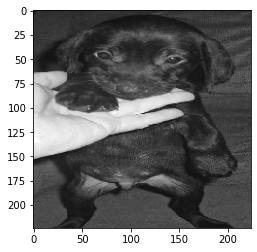

In [14]:
for i in range(0,1):
    image = img[i]
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()
#.astype('uint8')


# Build CNN

1-convoltion layer input are: number of the features , convolution window and the shape of each image
2- max pool input: is the window of max pooling

3-Here we apply Convolution filter=3*3 and grayscale image=(224,224,1)

In [0]:
# here we can replace img.shape[1:] by (224,224,1)
import tensorflow as tf
model=Sequential()
model.add(Convolution2D(32,(3,3),input_shape=img.shape[1:])) 
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Convolution2D(64,(3,3),input_shape=img.shape[1:]))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

# Dense layer is one dimentional data set while convolution is 2 dimentional dataset
model.add(Flatten())
model.add(Activation("relu"))

model.add(Dense(64))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation(tf.nn.softmax)) #sigmoid


In [17]:
model


In [18]:
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 222, 222, 32)      320       
_________________________________________________________________
activation_6 (Activation)    (None, 222, 222, 32)      0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
activation_7 (Activation)    (None, 109, 109, 64)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 186624)           

batch size tell you how many data pass at the time

optimizers in keras

http://www.machineintellegence.com/different-types-of-activation-functions-in-keras/

In [19]:
model.compile(optimizer="adam",loss='categorical_crossentropy',metrics=["categorical_accuracy"])
#binary_crossentropy
#categorical_crossentropy


By setting verbose 0, 1 or 2 you just say how do you want to 'see' the training progress for each epoch.

verbose=0 shows you nothing (silent)

verbose=1 shows you an animated progress with a progress bar

verbose=2 shows the number of epoch:



steps_per_epoch: Total number of steps (batches of samples) to yield from generator before declaring one epoch finished and starting the next epoch. It should typically be equal to the number of unique samples of your dataset divided by the batch size.

In [20]:
valid_batches.samples

2023

In [21]:
model.fit_generator(
                generator=train_batches,
                validation_data=valid_batches,
                steps_per_epoch=150,#train_batches.samples(8005)/train_batches.batch_size(50),
                validation_steps=4,#valid_batches.samples/valid_batches.batch_size,
                verbose=2,
                shuffle=False,
                #callbacks=[checkpointer1], 
                epochs=10)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/10




 - 119s - loss: 0.7702 - categorical_accuracy: 0.5413 - val_loss: 0.6821 - val_categorical_accuracy: 0.6250
Epoch 2/10
 - 117s - loss: 0.6885 - categorical_accuracy: 0.5880 - val_loss: 0.6483 - val_categorical_accuracy: 0.6875
Epoch 3/10
 - 114s - loss: 0.6694 - categorical_accuracy: 0.6153 - val_loss: 0.5787 - val_categorical_accuracy: 0.8125
Epoch 4/10
 - 114s - loss: 0.6660 - categorical_accuracy: 0.6127 - val_loss: 0.6554 - val_categorical_accuracy: 0.6875
Epoch 5/10
 - 111s - loss: 0.6402 - categorical_accuracy: 0.6613 - val_loss: 0.6010 - val_categorical_accuracy: 0.8125
Epoch 6/10
 - 110s - loss: 0.6002 - categorical_accuracy: 0.6920 - val_loss: 0.5126 - val_categorical_accuracy: 0.7500
Epoch 7/10
 - 111s - loss: 0.5426 - categorical_accuracy: 0.7167 - val_loss: 0.5526 - val_categorical_accuracy: 0.7500
Epoch 8/10
 - 111s - loss: 0.5210 - categorical_accuracy: 0.7487 - 

# Test 

In [0]:
test_img,test_label=next(test_batches)


Here the values of the index of 1 appear in hot code. 0 means [1,0] and 1 means [0,1]

In [23]:
test_batches.class_indices


{'cats': 1, 'dogs': 0}

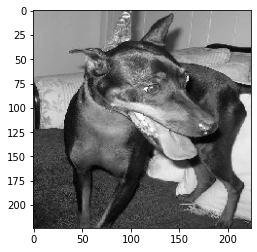

In [24]:
for i in range(0,1):
    image = test_img[i]
    plt.imshow(image[:,:,0], cmap='gray')
    plt.show()    
    

In [25]:
test_label[:,0]


array([1., 0., 1., 0.], dtype=float32)

In [0]:
predictor=model.predict_generator(test_batches,steps=1,verbose=0)


In [27]:
predictor[:,0].shape


(4,)

In [28]:
from sklearn.metrics import accuracy_score 
accuracy_score(test_label[:,0], predictor[:,0].round(), normalize=False)

3

In [29]:
confusion_matrix(test_label[:,0],predictor[:,0].round())


array([[1, 1],
       [0, 2]])

In [0]:
model.save('dog_cat_CNN.model')


Get 10 sample of the batches